In [1]:
import os
import cv2
import json
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from mxifpublic.community.graph_utils import (count_mask_pixels_in_radius,
                                              threshold_graph_edges_by_distance,
                                              generate_graph_adj_matrix,
                                              calculate_edge_length_statistic)
from mxifpublic.plotting.plot import cell_typing_plot
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import ARGVA, GCNConv
from tqdm.notebook import tqdm

# Constants specification

In [3]:
# Specify a path to data downloaded from Zenodo source
path_to_publication_data = ''
path_cells = f'{path_to_publication_data}/IBEX/Frames/cell_type_segment_annotation.csv'
path_contours = f'{path_to_publication_data}/IBEX/Contours/'

random_state = 42

mask_paths = {
 'CD21': f'{path_to_publication_data}/IBEX/Signal_masks/',
 'CD31': f'{path_to_publication_data}/IBEX/Signal_masks/',
 'Lyve': f'{path_to_publication_data}/IBEX/Signal_masks/',
# Specify all markers of interest  
 #'CD23': '',
 #'CD35': '',
 #'CD68': '',
 #'DCSIGN': '',
 #'CD163': '',
 #'CD11c': '',
 #'CD39': '',
 #'CD49a': '',
 #'SMA': '',
 #'SPARC': '',
 #'CXCL13': '',
 #'Desmin': '',
 #'Vimentin': '',
 #'Lumican': '',
 #'Collagen': ''
}
radius = 100
node_fetures_to_add = ['center_x', 'center_y', 'cell_type', 'index']

distance_threshold = 200
center_x_col_name, center_y_col_name = 'center_x', 'center_y'

features_columns = [
    f'nb_num_pixels_{radius}_{marker}' for marker in mask_paths
]

# Data preparation

## Mask percentages calculation

In [4]:
cells = pd.read_csv(path_cells)
cells['cell_type'] = cells['macro_cell_type_for_community'].copy()
# Specify here other samples if needed
cells = cells[cells['sample_id'].isin(['HP9849', 'HP9976'])].reset_index(drop=True)
rois = []
for sample_id, sample_data in tqdm(cells.groupby('sample_id')):
    for mask_name in tqdm(mask_paths, leave=False):
        mask_path = mask_paths[mask_name]
        mask = cv2.imread(f'{mask_path}/{sample_id}/{mask_name}.tif',
                          cv2.IMREAD_UNCHANGED)
        mask[mask == 255] = 1
        neighbour_pixels = count_mask_pixels_in_radius(
            mask, sample_data[['center_x', 'center_y']].values, radius=radius)
        feature_name = f'nb_num_pixels_{radius}_{mask_name}'
        sample_data[feature_name] = neighbour_pixels
        node_fetures_to_add.append(feature_name)
    rois.append(sample_data)
cells = pd.concat(rois).reset_index(drop=True)
cells['cell_index'] = cells['index']

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

## Load segment contours

In [7]:
samples_contours = {}
cell_image_shapes = {}

for sample_id, roi_data in tqdm(cells.groupby('sample_id')):
    cur_path = (f'{path_contours}{sample_id}.json')

    with open(cur_path, 'r') as contours_file:
        contours = json.load(contours_file)
        cell_image_shapes[sample_id] = tuple(contours['shape'])
        contours = [np.array(c, dtype=np.int32) for c in contours['contours']]
    samples_contours[sample_id] = contours

  0%|          | 0/2 [00:00<?, ?it/s]

## Assemble graph

In [8]:
patient_graphs = dict()
cell_distances = []

for sample_id, roi_data in tqdm(cells.groupby('sample_id')):
    adjacency_matrix = generate_graph_adj_matrix(roi_data)
    adjacency_matrix = threshold_graph_edges_by_distance(adjacency_matrix, distance_threshold)
    median_edge_distance = calculate_edge_length_statistic(adjacency_matrix, distance_threshold)
    
    cell_distances.append(median_edge_distance)
    patient_graphs[sample_id] = (adjacency_matrix, median_edge_distance)

cell_distances = np.concatenate(cell_distances)

cell_distance_scaler = MinMaxScaler()
cell_distance_scaler.fit(cell_distances.reshape(-1, 1))

patient_graphs = {
    key: (adj, cell_distance_scaler.transform(dst.reshape(-1, 1)))
    for key, (adj, dst) in patient_graphs.items()
}

  0%|          | 0/2 [00:00<?, ?it/s]

# Dataset generation

In [9]:
cell_type_encoder = OneHotEncoder(sparse=False)
cell_type_encoder.fit(cells['cell_type'].values.reshape(-1, 1))

cohort_graph_dataset = []

for sample_id, roi_data in tqdm(cells.groupby('sample_id')):
    adjacency_matrix, median_edge_distance = patient_graphs[sample_id]
    edge_indices, _ = from_scipy_sparse_matrix(adjacency_matrix)
    cell_types = cell_type_encoder.transform(roi_data['cell_type'].values.reshape(-1, 1))
    
    mask_percentages = roi_data[features_columns]

    node_data = np.concatenate([cell_types, median_edge_distance, mask_percentages], axis=1)

    sample_data_object = Data(edge_index=edge_indices,
                              x=torch.Tensor(node_data).float(),
                              contour_index=cells['cell_index'],
                              sample_id=sample_id)

    cohort_graph_dataset.append(sample_data_object)

  0%|          | 0/2 [00:00<?, ?it/s]

# Training

## Configuration

In [10]:
# +1 is required for median distance
in_channels = len(cells['cell_type'].unique()) + len(mask_paths) + 1
model_encoder_configuration = [in_channels, 32, 32]
model_decoder_configuration = [32, 64, 32]
device = 'cpu'
num_epochs = 10
num_repeat_discriminator = 5
discriminator_lr = 0.001
encoder_lr = 0.005
save_models_dir = 'models'
features_num = model_encoder_configuration[2]
n_communities = 15

## Model

In [11]:
class Encoder(torch.nn.Module):
    def __init__(self, in_channels: int, hidden_channels: int, out_channels: int):
        super(Encoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, cached=False)
        self.conv_mu = GCNConv(hidden_channels, out_channels, cached=False)
        self.conv_logstd = GCNConv(hidden_channels, out_channels, cached=False)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


class Discriminator(torch.nn.Module):
    def __init__(self, in_channels: int, hidden_channels: int, out_channels: int):
        super(Discriminator, self).__init__()
        self.lin1 = torch.nn.Linear(in_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.lin3 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        return x


In [12]:
encoder = Encoder(*model_encoder_configuration)
discriminator = Discriminator(*model_decoder_configuration)
model = ARGVA(encoder, discriminator)

device = torch.device(device if torch.cuda.is_available() else 'cpu')
model.train()
model.to(device);

## Train loop

In [13]:
os.makedirs(save_models_dir, exist_ok=True)
discriminator_optimizer = torch.optim.Adam(model.discriminator.parameters(), lr=discriminator_lr)
encoder_optimizer = torch.optim.Adam(model.encoder.parameters(), lr=encoder_lr)
best_loss = 10**9

dataloader = DataLoader(cohort_graph_dataset, batch_size=1, shuffle=True)
loss_history = []
for epoch in tqdm(range(num_epochs)): 
    mean_epoch_loss = []
    for data_train in dataloader:
        encoder_optimizer.zero_grad()
        data_train = data_train.to(device)
        
        z = model.encode(data_train.x, data_train.edge_index)

        for i in range(num_repeat_discriminator):
            discriminator_optimizer.zero_grad()
            discriminator_loss = model.discriminator_loss(z)
            discriminator_loss.backward()
            discriminator_optimizer.step()

        loss = model.recon_loss(z, data_train.edge_index)
        loss = loss + model.reg_loss(z)
        loss = loss + (1 / data_train.num_nodes) * model.kl_loss()
        
        loss.backward()
        encoder_optimizer.step()
        
        mean_epoch_loss.append(loss.item())
    
    mean_epoch_loss = np.mean(mean_epoch_loss)
    loss_history.append(mean_epoch_loss)
    print(f'Epoch: {epoch} Mean epoch loss: {mean_epoch_loss}')
    
    if best_loss > mean_epoch_loss:
        best_loss = mean_epoch_loss
        torch.save(model.state_dict(), f'{save_models_dir}/community_model_{mean_epoch_loss:.4f}.pth')

/home/avarlamova/env_t/lib/python3.8/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 Mean epoch loss: 5.616163492202759
Epoch: 1 Mean epoch loss: 5.269151926040649
Epoch: 2 Mean epoch loss: 4.952280521392822
Epoch: 3 Mean epoch loss: 4.66521430015564
Epoch: 4 Mean epoch loss: 4.371762037277222
Epoch: 5 Mean epoch loss: 4.089988946914673
Epoch: 6 Mean epoch loss: 3.7929961681365967
Epoch: 7 Mean epoch loss: 3.5399199724197388
Epoch: 8 Mean epoch loss: 3.342698574066162
Epoch: 9 Mean epoch loss: 3.24667227268219


## Loss history

Text(0.5, 1.0, 'Loss history')

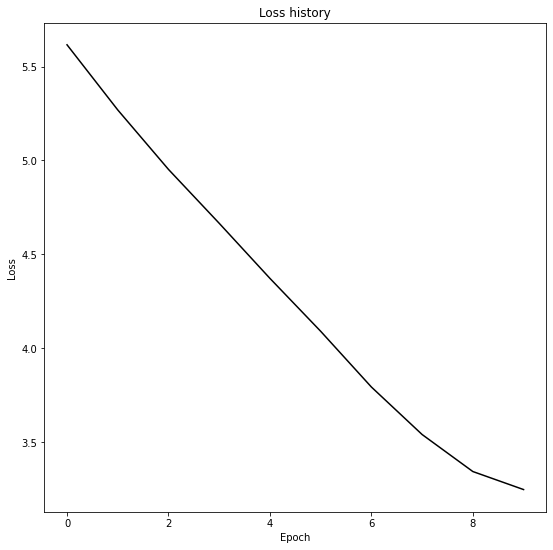

In [14]:
plt.figure(figsize=(9, 9))
plt.plot(loss_history, color='black')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss history')

## Inference

In [15]:
model = model.to(device)
model.load_state_dict(torch.load(f'{save_models_dir}/community_model_{best_loss:.4f}.pth',
                                 map_location=device))
cohort_embeddings = []
for sample_data_object in tqdm(cohort_graph_dataset):
    sample_id = sample_data_object.sample_id
    with torch.no_grad():
        model.eval()
        x, edge_index = (sample_data_object.x.to(device), 
                         sample_data_object.edge_index.to(device))

        z = model.encode(x, edge_index)
        z = z.squeeze()
        z = z.detach().cpu().numpy()

    node_embeddings = pd.DataFrame(z)
    node_embeddings['sample_id'] = sample_id
    node_embeddings['cell_index'] = sample_data_object.contour_index
    cohort_embeddings.append(node_embeddings)
    
cohort_embeddings = pd.concat(cohort_embeddings)
cohort_embeddings = cohort_embeddings.reset_index(drop=True)

  0%|          | 0/2 [00:00<?, ?it/s]

## Cluster embedding

In [16]:
clusterer = MiniBatchKMeans(n_clusters=n_communities, random_state=random_state)
embedding_clusters = clusterer.fit_predict(cohort_embeddings[list(range(features_num))].values)
embedding_clusters = pd.Series(embedding_clusters, name='graph_cluster')
embedding_clusters = 'cluster_' + embedding_clusters.apply(str)
cohort_embeddings['graph_cluster'] = embedding_clusters

## Relative content

Text(0, 0.5, 'Community relative content')

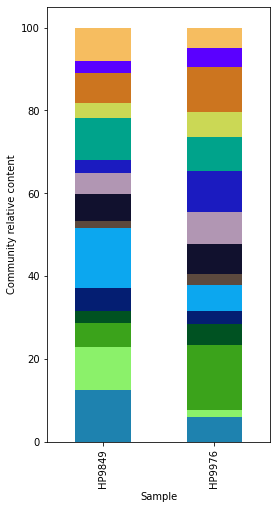

In [17]:
colors = [
 '#11112e',
 '#0ca7ef',
 '#1b1bc0',
 '#041e72',
 '#5A00FF',
 '#CBD855',
 '#3BA31B',
 '#005222',
 '#1E82AF',
 '#00A38B',
 '#8BF16A',
 '#cc751f',
 '#f6bd60',
 '#5C493E',
 '#b196b3'
]
# Palette is generated only if there are less than 16 community clusters
assert n_communities <= len(colors)
colors = random.sample(colors, n_communities)
palette = {cluster: color for cluster, color in zip([f'cluster_{i}' for i in range(n_communities)], 
                                                     colors)}
pivot = pd.pivot_table(cohort_embeddings, 
                       index='sample_id',
                       columns='graph_cluster',
                       values='cell_index',
                       aggfunc=len,
                       fill_value=0)
pivot = pivot.div(pivot.sum(axis=1), axis=0) * 100
fig, ax = plt.subplots(1, 1, figsize=(4, 8))
pivot.plot.bar(stacked=True, legend=False, 
               ax=ax, color=palette)
plt.xlabel('Sample')
plt.ylabel('Community relative content')

## Visualization

(-0.5, 12087.5, 11116.5, -0.5)

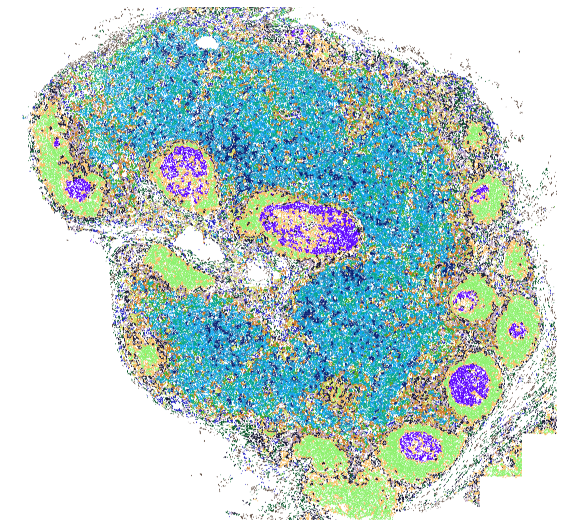

In [18]:
sample_id = list(cell_image_shapes.keys())[0]
height, width = cell_image_shapes[sample_id]
roi_data = cohort_embeddings[cohort_embeddings['sample_id'] == sample_id]\
           .set_index('cell_index')['graph_cluster']
image = cell_typing_plot(roi_data, samples_contours[sample_id],
                         palette=palette, width=width, height=height)
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis(False)